In [1]:
using Plots
using HDF5
using Unitful
using Statistics
using Dates
using Plots.PlotMeasures
using GeoDatasets

# Load Filter output file

In [7]:
field = "ps" # Choose from the fields listed above
unit_comp = 0.01 # Convert Pa to hPa
field_unit = "hPa"
output_folder = "reviewer_setup"
# Open the output file
fh = h5open(joinpath(output_folder, "optimal.h5"), "r");

# Open the Naive Ensmeble
fh_naive = h5open(joinpath(output_folder, "naive.h5"), "r");

# Open the Nature Run
th = h5open(joinpath(output_folder, "obs.h5"), "r");

### Read in the Coordinates


In [8]:
## Read in the coordinates
timestamp = "t0000"
x_unit = read(fh["grid_coordinates"]["lon"]["Unit"])
y_unit = read(fh["grid_coordinates"]["lat"]["Unit"])
x_st_unit = read(fh["station_coordinates"]["lon"]["Unit"])
y_st_unit = read(fh["station_coordinates"]["lat"]["Unit"])

field_desc = read(fh["state_avg"][timestamp][field]["Description"])

x = read(fh["grid_coordinates"]["lon"]) .* uparse(x_unit) .|> u"°"
y = read(fh["grid_coordinates"]["lat"]) .* uparse(y_unit) .|> u"°"


x_st = read(fh["station_coordinates"]["lon"]) .* uparse(x_st_unit) .|> u"°"
y_st = read(fh["station_coordinates"]["lat"]) .* uparse(y_st_unit) .|> u"°"

50-element Vector{Quantity{Float64, NoDims, Unitful.FreeUnits{(°,), NoDims, nothing}}}:
                0.0°
  11.48936170212766°
 19.148936170212767°
 30.638297872340427°
 30.638297872340427°
 38.297872340425535°
 38.297872340425535°
 38.297872340425535°
 49.787234042553195°
 49.787234042553195°
                   ⋮
  130.2127659574468°
  130.2127659574468°
 141.70212765957447°
 141.70212765957447°
 141.70212765957447°
 149.36170212765958°
 149.36170212765958°
 160.85106382978725°
 168.51063829787236°

### Set up the dates array

In [9]:
IDate = "1982010100"
endDate = "1982080100"
SPEEDY_DATE_FORMAT = "YYYYmmddHH"
dates = collect(DateTime(IDate, SPEEDY_DATE_FORMAT):Dates.Hour(6):DateTime(endDate, SPEEDY_DATE_FORMAT));

# Spatial RMSE

In [10]:
function spatial_error(ens_file, truth_file, len, error_type)
    nlon = 96
    nlat = 48
    level = 1
    spatial_err = zeros(nlon, nlat, len)
    for it = 0:len-1
        timestamp = "t" * lpad(string(it),4,'0')
        z_truth = read(truth_file["state"][timestamp][field]).*unit_comp
        z_avg = read(ens_file["state_avg"][timestamp][field]).*unit_comp
        
        if error_type == "Lmax"
            spatial_err[:,:,it+1] .= abs.(z_truth[:,:,level] - z_avg[:,:,level])
        else
            spatial_err[:,:,it+1] .= ((z_truth[:,:,level] - z_avg[:,:,level]).^2)
        end

    end

    if error_type == "Lmax"
        ret_err = maximum(spatial_err, dims=3)
    else
        ret_err = sqrt.(mean(spatial_err, dims=3))
    end

    return ret_err
end


len = length(keys(fh["state_avg"]))
ens_error = spatial_error(fh, th, len, "L2");
naive_error = spatial_error(fh_naive, th, len, "L2");



## Plotting the Error Fields

In [11]:
function plot_error_std(x, y, lon_coast, lat_coast, z_t, z_avg, ens_error, naive_error, date, x_st, y_st, coast_outline)

    p1 = heatmap(x, y, transpose(z_t); title="Surface Pressure \n $date")
    p1 = Plots.contour!(lon_coast, lat_coast, 800*(coast_outline)', c = :blues)

    p2 = heatmap(x, y, transpose(z_avg); title="Assimilated Surface Pressure (μ) \n $date")
    p2 = Plots.contour!(lon_coast, lat_coast, 800*(coast_outline)', c = :blues)

    p3 = heatmap(x, y, transpose(ens_error); title="Time averaged error for the ensemble \n (assimilation)")
    p3 = Plots.contour!(lon_coast, lat_coast, 5*(coast_outline)', c = :blues)

    p4 = heatmap(x, y, transpose(naive_error); title="Time averaged error for the ensemble \n (no assimilation)")
    p4 = Plots.contour!(lon_coast, lat_coast, 5*(coast_outline)', c = :blues)

    for (i, plt) in enumerate((p1, p2, p3, p4))
        # Set labels
        i ∈ (2) && Plots.plot!(plt; labelfontsize=20, tickfontsize=18)
        i ∈ (1,3) && Plots.plot!(plt; ylabel="Lat (°)", labelfontsize=20, tickfontsize=18)
        i ∈ (3,4) && Plots.plot!(plt; xlabel="Lon (°)", labelfontsize=20, tickfontsize=18)
        # Set range of color bar for first two plots
        i ∈ (1, 2) && plot!(plt; clims=(minimum(ustrip(z_t)), maximum(ustrip(z_t))))
        i ∈ (3, 4) && plot!(plt; clims=(0.0, maximum(ustrip(naive_error))))
        # Add the positions of the stations
        i ∈ (1, 2, 3, 4) && Plots.scatter!(plt, x_st, y_st, color=:black, marker=:star, label="Observation Locations")
    end
    l = @layout[grid(2, 2)]
    Plots.plot(p1, p2, p3, p4, layout = l, titlefontsize=24, guidefontsize=20, colorbar_titlefontsize = 20, legendfontsize=12, legendtitlefontsize=12, left_margin = 40px, right_margin = 40px, bottom_margin = 40px, dpi=300)
    Plots.plot!(size=(2100,1700))
    Plots.savefig("reviewer_setup/speedy_runs_ensemble.png")
    Plots.savefig("reviewer_setup/speedy_runs_ensemble.pdf")
end

lon_coast, lat_coast, landsea = GeoDatasets.landseamask(;resolution='c',grid=10)
coast = zeros(size(landsea))
landsea[landsea .== 2] .= 1

# Flip the coast data
coast[1:1080, 1:1080] .= landsea[1081:2160,1:1080]
coast[1081:2160,1:1080] .= landsea[1:1080, 1:1080]

lon_coast = lon_coast .+ 180
lat_coast = lat_coast .+ 90

x_plot = range(0,360,96)
y_plot = range(0,180,48)

timestamp = "t0250"
number = parse(Int64, split(timestamp,'t')[2]);

# Read in state at timestamp and scale to hPa
z_truth = read(th["state"][timestamp][field]) .* uparse(field_unit).*unit_comp
z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit).*unit_comp

plot_error_std(x_plot, y_plot, lon_coast, lat_coast, z_truth[:,:,1], z_avg[:,:,1], ens_error[:,:,1].* uparse(field_unit), naive_error[:,:,1].* uparse(field_unit), dates[number+1], ustrip(x_st), ustrip(y_st), coast)


"/Users/dangiles/Documents/Stats/RADDISH/ParticleDA-UseCases/SPEEDY/results/revision_3/reviewer_setup/speedy_runs_ensemble.pdf"

## Estimated Ensemble Size

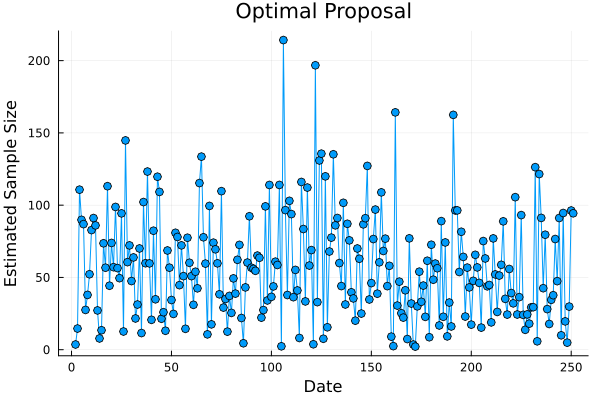

In [15]:
plot([1 / sum(read(w) .^ 2) for w in fh["weights"]];
     label="", marker=:o, xlabel="Date", ylabel="Estimated Sample Size", title="Optimal Proposal")